## House Prices: Advanced Regression Techniques

W207 Final Project
<br>
Teddy Fong, Ross MacLean, Alex West

The dataset selected for this project was obtained from Kaggle's current list of open competitions (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). This competition uses the Ames Housing Dataset compiled by Dean De Cock.

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.  

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.  The following workbook document's our team's process in full - from exploratory data analysis, to preprocessing, model selection and evaluation.

**Outline**

**I. Exploratory Data Analysis**
- i. Missing Values
- ii. Correlations
- iii. The Dependent Variable: SalePrice
- iv. Combine Datasets and Replace Missing Values
- v. Encoding the Data
-- Label Encoding
-- One Hot Encoding 
- vi. Split the Data
- vii. Transformations

**II. Model Building**

In [1]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Preprocessing and stats libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import stats

# SK-learn libraries for regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

# SK-learn libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [4]:
# Read in the housing train data
train = pd.read_csv('./Data/train.csv', index_col=0)
train.reset_index(drop=True, inplace=True)

# Read in the test data
test = pd.read_csv('./Data/test.csv', index_col=0)

# Shapes of datasets
print('Train data:', np.array(train).shape)
print('Test data:', np.array(test).shape)

Train data: (1460, 80)
Test data: (1459, 79)


### Missing Values

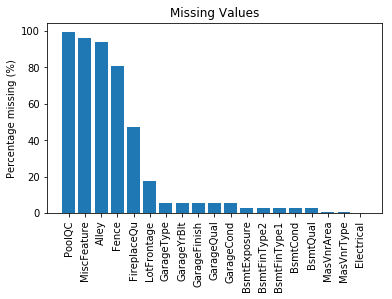

In [5]:
def plot_missing(train=train):
    '''Plot all features with missing values. Accepts
    dataframe as input. Displays bar graph showing
    percentage of missing values by feature.
    '''
    # Calculate missing value counts
    missing = train.isnull().sum()
    missing = pd.DataFrame(missing[missing > 0])

    # Rename and sort counts
    missing.columns = ['count']
    missing.sort_values(by='count', ascending = False, inplace = True)

    # Percentage missing
    missing['percent_missing'] = missing['count'] / len(train.index) * 100

    # Plot missing counts
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(missing.index, missing['percent_missing'])
    plt.title('Missing Values')
    plt.ylabel('Percentage missing (%)')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
plot_missing()

In [6]:
def return_variable_types(data=train):
    '''Divide dataset columns into qualitative and quantitative array.
    Accepts training data as an input.  Returns a list containing
    list elements of qualitative and quantitative feature names.
    '''
    # Group variables by type
    qualitative = [var for var in data.columns if np.dtype(data[var]) == 'object'].copy()
    quantitative = [var for var in data.columns if np.dtype(data[var]) != 'object'].copy()
    
    return qualitative, quantitative

In [7]:
def replace_missing(data=train):
    '''Replace missing values for qualitative and quantitative
    variables accordingly. Accepts dataframe as an input. 
    Outputs a new dataset with missing values replaced.
    '''

    # Group variables by type
    qualitative, quantitative = return_variable_types(data=data)

    # Identify missing values
    missing = data.columns[data.isnull().any()]

    # Replace with appropriate value according to type
    for col in missing:
        if col in qualitative:
            data[col] = data[col].fillna('None')
        elif col in quantitative:
            data[col] = data[col].fillna(0)      
    return data

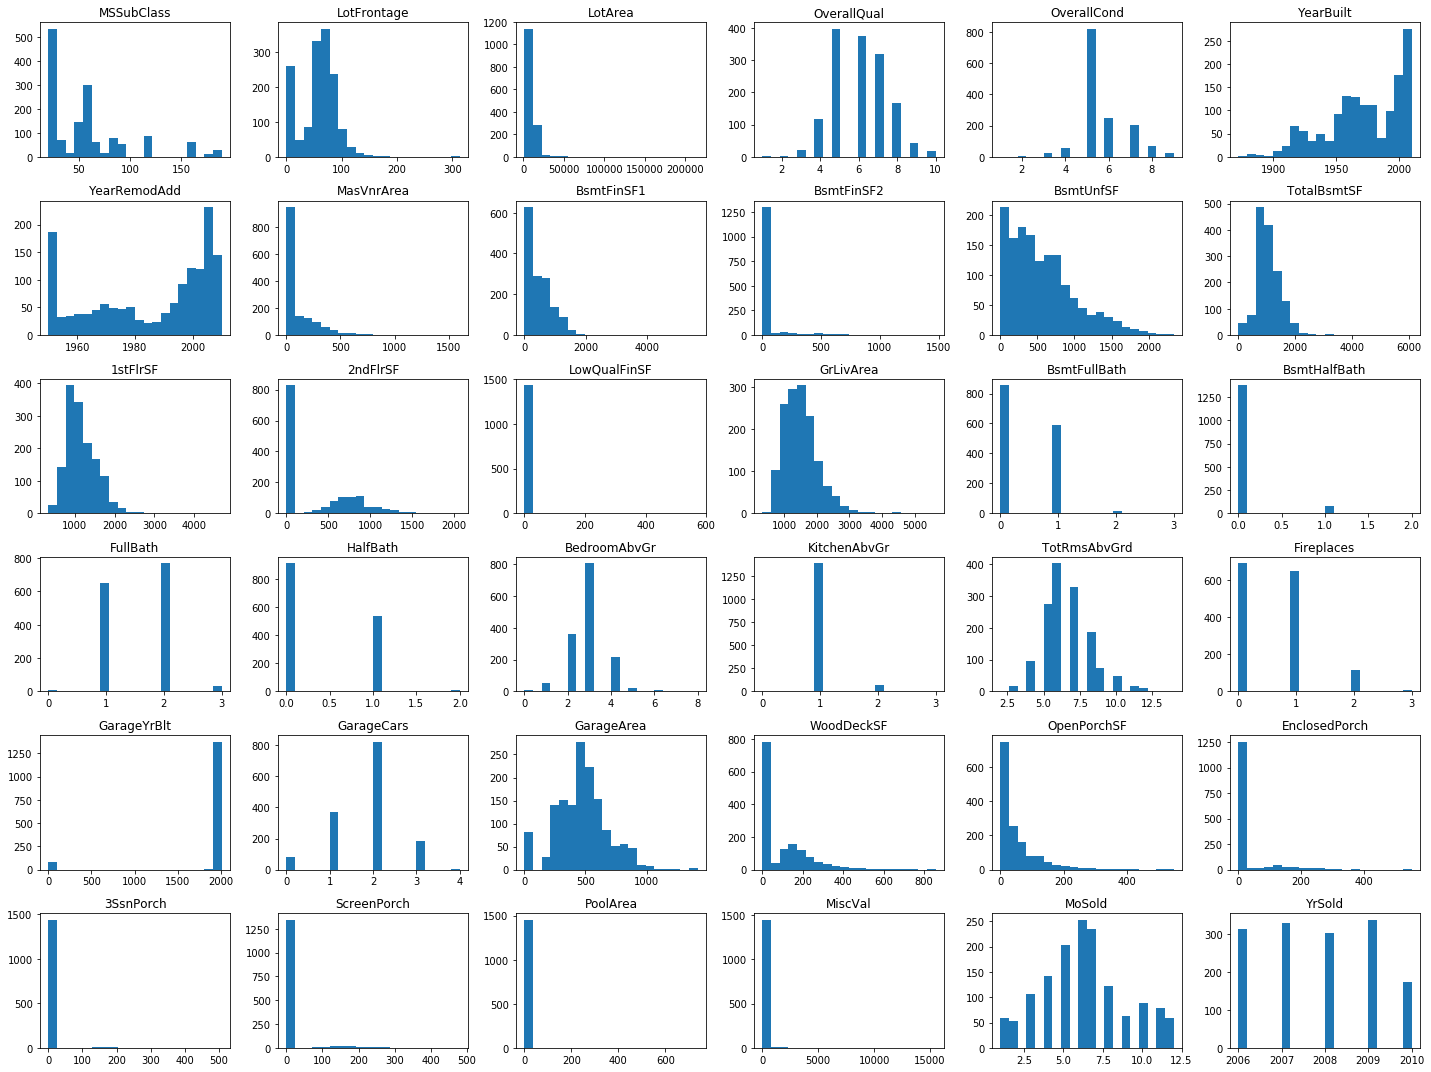

In [8]:
def plot_distribution_quants(train=train):
    '''Plot the distributions of all quantitative variables
    contained in the raw training data.'''

    # Replace missing for train
    train_data = replace_missing(train)

    # Plot distributions of quantitative variables 
    fig, axes = plt.subplots(6,6, figsize = (20,15)) 
    quantitative = return_variable_types(data=train)[1][:-1]
    
    # Loop through each column
    for i, col in enumerate(quantitative):
        
        # Unravel axes and plot
        ax = axes.ravel()[i]
        ax.set_title(col)
        ax.hist(train_data[col], bins=20, density=False)

    fig.tight_layout()
    
plot_distribution_quants()

### Correlations

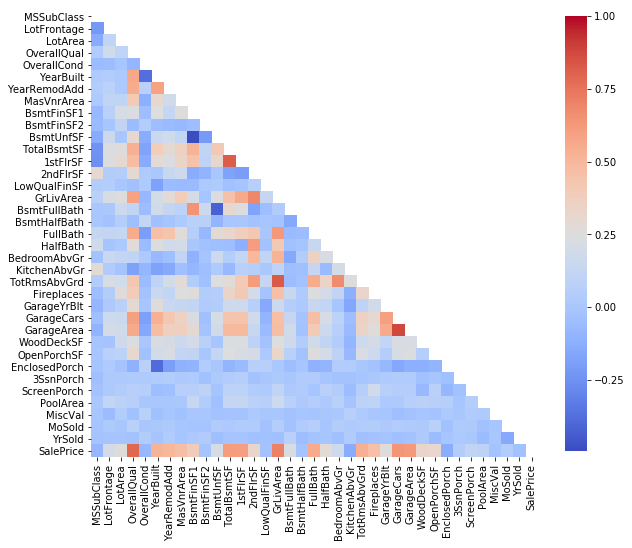

In [9]:
def correlation_matrix(train=train):
    '''Plot correlation matrix for dataset. Accepts
    dataframe as input. Displays upper triangular
    heat map of correlations.
    '''  
    # Create correlation matrix
    corr = train.corr()

    # Define figure size
    plt.rcParams['figure.figsize'] = (10, 10)

    # Mask upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot heapmat
    sns.heatmap(corr, mask=mask, square=True, cmap='coolwarm', cbar_kws={"shrink": 0.8})
    
correlation_matrix()   

The correlation plot shows there are a number of variables that are highly correlated, e.g. Overall Quality and Sale Price.  The extent to which the different variables are correlated will need to be taken into consideration when selecting the appropriate regression model.  For instance, we'll want to avoid a high degree of multicollinearity in order to minimize the bias with our model.



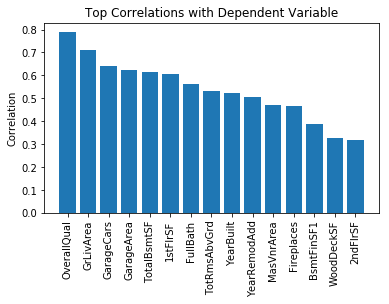

In [10]:
def plot_top_correlations(train=train, n=15):
    '''Plot the top n features that are positively correlated
    with sales price.  Accepts inputs of dataframe and integer
    of top n features to display.  Outputs bar graph of top n
    features by correlation strength.
    '''
    # SalePrice correlations
    corr = train.corr()
    saleprice_corr = pd.DataFrame(corr.loc[['SalePrice'], :].unstack())

    # Reformat df and sort
    saleprice_corr.rename(columns= {0: 'SalePrice'}, inplace = True)
    saleprice_corr.reset_index(level=1, drop=True, inplace=True)
    saleprice_corr.sort_values(by='SalePrice', ascending = False, inplace = True)

    # Top 15 variables most strongly correlated with SalePrice
    saleprice_top_15 = saleprice_corr.iloc[1:n+1, :]
    
    # Plot top correlations
    fig, ax = plt.subplots(figsize = (6,3.5))
    plt.bar(saleprice_top_15.index, saleprice_top_15['SalePrice'])
    plt.title('Top Correlations with Dependent Variable')
    plt.ylabel('Correlation')

    # Rotate x labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

plot_top_correlations()

The 15 variables displayed above are those most strongly correlated with SalePrice, our dependent variable.  It's worth noting that some of thse variables are highly correlated with one another (e.g. GarageCars/GarageArea, GrLivArea/1stFlrSF) and so such pairings should be avoided when specifying the linear regression model so as not to confound results.

### The Dependent Variable - Sale Price

In [11]:
print('Descriptive stats for sale price:')
pd.DataFrame(round(train.SalePrice.describe(),2))

Descriptive stats for sale price:


,SalePrice
count,1460.0
mean,180921.2
std,79442.5
min,34900.0
25%,129975.0
50%,163000.0
75%,214000.0
max,755000.0


The target variable SalePrice:

- Deviates from the normal distribution.
- appreciable positive skewness.
- Shows peakedness.

We will therefore transform SalePrice into LogSalePrice.

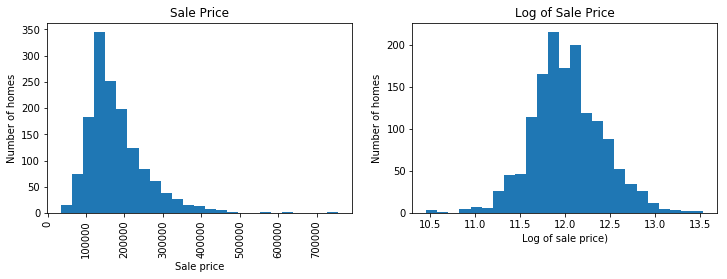

In [12]:
def plot_sale_price(train=train):
    '''Plots the distribution of sales prices (dependent variable).
    Accepts dataframe as input.  Displays distribution of sales
    prices (untransformed) and transformed logarithmically.
    '''
    # Define figure
    fig, axes = plt.subplots(1,2, figsize = (12,3.5))

    # Histogram of sale price
    axes[0].hist(train.SalePrice, bins=25)
    axes[0].set_title('Sale Price')
    axes[0].set_xlabel('Sale price')
    axes[0].set_ylabel('Number of homes')

    # Rotate x labels
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

    # Histogram of log(sale price) 
    axes[1].hist(np.log(train.SalePrice), bins=25)
    axes[1].set_title('Log of Sale Price')
    axes[1].set_xlabel('Log of sale price)')
    axes[1].set_ylabel('Number of homes')

plot_sale_price()

### Combine Datasets and Replace Missing Values

In [13]:
def create_full_dataset(train=train, test=test):
    '''Combine train and test data into a full dataset to enable
    transformations to be applied more easily. Accepts inputs
    of train data and test data.  Outputs a full dataset with
    all features, minus the dependent variable (sales price).
    '''
    # Create full data without SalePrice
    full_data = pd.concat((train.loc[:, train.columns != 'SalePrice'], test)).reset_index(drop=True)

    # Replace with appropriate value according to type
    full_data = replace_missing(data=full_data)  
    return full_data.copy()

### Encoding the Data

In this project, regressors are being used to predict the output variable, sale price.  Therefore it is necessary to transform all strings to suitable numerical values before passing the dataset to the regressor.  This transformation can be done using either label encoding or one hot encoding.  Unfortunately, it seems it is not possible to incorporate label encoding or one hot encoding as a preprocessing step in our pipeline.  As such it is necessary to encode our dataset before passing to our regression model.

Label encoding transforms all strings values to an integer, e.g. Neighborhood's of NorthAmes, OldTown and Sawyer are transformed to 1, 2 and 3 respectively.  The issue here is that their numerical representations may be interpreted as ordinal when in fact there's no ordinal relationship is present.  For instance, our model may incorrectly interpret that as neighborhood number increases, so too does sale price.

An alternative option is to apply one hot encoding which effectively creates binary flags for each values.  Reusing using the previous example, three new variables would be created to represent the 3 neighborhoods.  While this approach mitigates against the issue of creating fictitious ordinal relationships, it greatly increases our feature space.

#### Label Encoding

In [14]:
def label_encoder(full_data, columns):
    '''Label encode specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a label encoded data frame.
    '''
    # Label encode all qualitative variables
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(full_data[col].values)) 
        full_data[col] = label_encoder.transform(list(full_data[col].values))
    return full_data

#### One Hot Encoding

In [15]:
def one_hot_encoder(full_data, qualitative, quantitative):
    '''One hot encodes specified dataframe columns. Accepts
    inputs of pandas dataframe and columns to be encoded.
    Outputs a one hot encoded data frame.
    '''
    encoded = full_data[quantitative]
        
    # One hot encode all qualitative variables
    for col in qualitative:
        dummies = pd.get_dummies(full_data[col], prefix=col, sparse=False, drop_first=False)
        encoded = pd.concat([encoded, dummies], axis=1)
    return encoded

### Split the Data

In [16]:
def split_full_dataset(full_data, train=train):
    '''Splits the full dataset into required component parts
    for model training/testing.  Accepts inputs of full_data
    and train data. Outputs dataframes of train_data,
    train_labels, dev_data dev_labels, test_data.
    '''
    # Cut point for train/test post feature engineering
    cut = train.shape[0]
    
    # Recreate train and test sets
    train_data = full_data[:cut]
    y_label = list(train.loc[:, 'SalePrice'])
    train_data.loc[:, 'SalePrice'] = y_label
    test_data = full_data[cut:]

    # Random splits for train and dev sets
    train_set = train_data.sample(frac=0.8, random_state=0)
    dev_set = train_data.drop(train_set.index)

    # Select specified features for each dataset
    train_data, train_labels = train_set.loc[:, train_set.columns != 'SalePrice'], train_set.loc[:, 'SalePrice']
    dev_data, dev_labels = dev_set.loc[:, dev_set.columns != 'SalePrice'], dev_set.loc[:, 'SalePrice']
    
    return train_data, train_labels, dev_data, dev_labels, test_data

In [17]:
# Scoring function as per Kaggle competition

def root_mean_squared_error(y_value, y_predict):
    '''Calculate the root mean square error (RMSE). Accepts
    inputs of actual y value and predicted y value. Returns
    the RMSE as a float.
    '''
    return np.sqrt(mean_squared_error(y_value, y_predict))

### Transformations

In [18]:
def transform_data(train=train, test=test, encoder='none'):
    
    full_transformed = create_full_dataset(train=train, test=test).copy()
    
    full_transformed['MSSubClass'] = full_transformed['MSSubClass'].astype(str)
    full_transformed['OverallCond'] = full_transformed['OverallCond'].astype(str)
    full_transformed['OverallQual'] = full_transformed['OverallQual'].astype(str)
    full_transformed.drop(columns='Street', inplace=True)
    
    # Encode transformed dataset
    qualitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) == 'object'].copy()
    quantitative = [var for var in full_transformed.columns if np.dtype(full_transformed[var]) != 'object'].copy()
    
    if encoder == 'label_encoder':
        full_transformed = label_encoder(full_transformed, qualitative)
    elif encoder == 'onehot_encoder':
        full_transformed = one_hot_encoder(full_transformed, qualitative, quantitative)
    else:
        full_transformed

    
    return full_transformed

## Model Building

### Basic Linear Model

In [19]:
def linear_regression(train=train, test=test, encoder='none'):
    '''Fit linear regression model, predict dependent variable and
    display scatter plot with regression line and residual plot.
    Accepts inputs of full_data and encoding type (none, label or
    one hot). Returns model accuracy, RMSE and plots.
    '''
    full_data = transform_data(train=train, test=test, encoder=encoder)
    print(full_data.shape)

    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    
    # Log of sales price
    train_labels_log = np.log(train_labels)
    dev_labels_log = np.log(dev_labels)

    # Fit the linear regression model
    lr = LinearRegression()
    lr.fit(train_data, train_labels_log)
    predict_dev_log = lr.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Plot predicted vs. actual values
    fig, axes = plt.subplots(1,2,figsize = (11.5,4))
    
    # Calculate regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(dev_labels, predict_dev_value)
    line_x = np.arange(dev_labels.min(), dev_labels.max())
    line_y = slope*line_x + intercept
    
    # Plot data and regression line
    axes[0].scatter(dev_labels, predict_dev_value)
    axes[0].plot(line_x, line_y, color='red', linestyle = '--')

    axes[0].set_title('Linear regression: Actual vs. Predicted')
    axes[0].set_xlabel('Actual price')
    axes[0].set_ylabel('Predicted price')
    
    # Plot residuals
    axes[1].scatter(predict_dev_value, predict_dev_value - dev_labels, color='black', s=20)
    axes[1].hlines(y=0, xmin= 0, xmax=500000, colors='red')
    
    axes[1].set_title('Residuals: Variance of Fitted Values')
    axes[1].set_xlabel('Predicted price')
    axes[1].set_ylabel('Variance from actual')
    axes[1].set_ylim(-160000,150000)
    
    fig.tight_layout()
    
    # R^2 and root mean squared error
    print('Accuracy: {:.4f}'.format(lr.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))

Linear regression with label encoding
(2919, 78)
Accuracy: 0.8690
RMSE: 0.1354


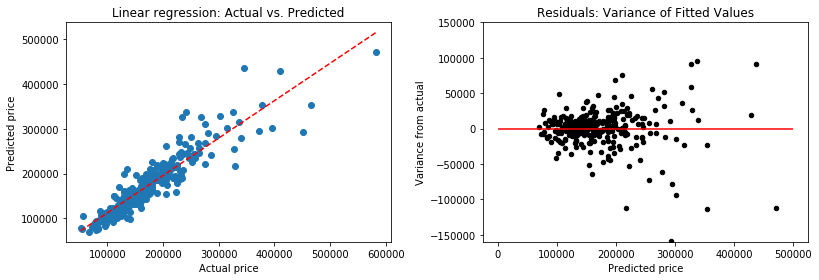

In [20]:
print('Linear regression with label encoding')
linear_regression(encoder='label_encoder')

The basic linear regression model with label encoding acheived an R^2 of 0.8761 when predicting on the dev data.  It should be noted however that as house price increases, there's a tendancy for the predicted value to exhibit greater variance from the true sale price.  This is confirmed by the above residual plot, revealing the presence of non-constant variance, i.e. heteroskedasticity.

The residual plot also shows tendancy toward greater variance as house price increases (non-constant variance), again indicating that our modeling process may benefit from further preprocessing (e.g. transforming features, removing outliers) and regularization.


Linear regression with one hot encoding
(2919, 340)
Accuracy: 0.8872
RMSE: 0.1256


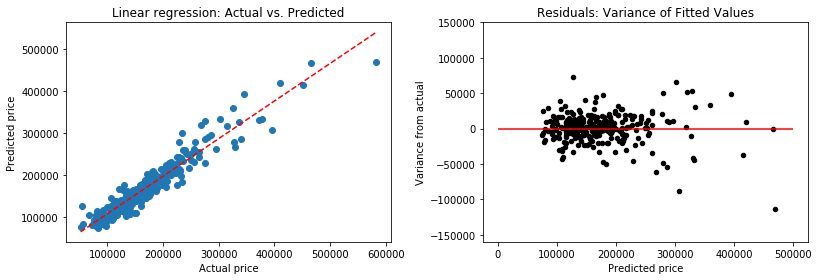

In [21]:
print('Linear regression with one hot encoding')
linear_regression(encoder='onehot_encoder')

The basic linear regression model with one hot encoding acheived an R^2 of 0.9159, representing an increase of 0.0407 compared to label encoding.  This improvement can be attributed to the fact that one hot encoding ensures that the linear regression model will not interpret any false ordinal relationships in the data (as is the case with label encoding) however it comes at a price.  The feature space has now increased our feature space almost 4-fold, from 79 to 310 features.

As we add more features to our model, it's complexity increases which in turn increases variance and reduces bias.  This makes the model more prone to overfitting.  The goal is to fit the optimal point where the decrease in bias is equal to the increase in varaince.  To achieve this it is necessary to either reduce model complexity or introduce regularization.  The next section will look at the effect of Lasso Regression - which uses L2 regularization to select features with the greatest coefficients - on the predictive power.

### Lasso Regression

In [22]:
def lasso_regression(train=train, test=test):
    '''Fit lasso regression model, make predictions and
    display results. Accepts input of full_data and
    returns (prints) model accuracy and RMSE.
    '''
    # Lasso with alpha=0 is the same as OLS.
    # Accuracy should match basic linear regression (it does).

    full_data = transform_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Lasso - fit the model
    lasso = Lasso(alpha=0.0, normalize=True)
    lasso.fit(train_data, train_labels_log)

    # Make prediction
    predict_dev_log = lasso.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # Print accuracy/results
    print('Lasso regression')
    print('Accuracy: {:.4f}'.format(lasso.score(dev_data, dev_labels_log)))
    print('RMSE: {:.4}'.format(root_mean_squared_error(dev_labels_log, predict_dev_log)))

lasso_regression()

Lasso regression
Accuracy: 0.8690
RMSE: 0.1354


In [23]:
def lasso_grid_search(train=train, test=test):
    '''Fit GridSearchCV using lasso regression for various
    alpha. Accepts input of full_data and returns (prints)
    the best model score and corresponding alpha.
    '''
    full_data = transform_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Parameters
    model = Lasso(normalize=True)
    param_grid = {'alpha': np.arange(0,10,0.2)}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_search.fit(train_data, train_labels_log)

    # Make predictions
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)

    # summarize the results of the grid search
    print('Lasso regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.alpha))
    
lasso_grid_search()

Lasso regression
Best score: 0.808
Best estimator: 0.0


In [24]:
def optimize_regressor(pipe, param_grid, train=train, test=test):
    '''Optimizes regression model using grid search.
    Accepts inputs of pipeline (list of tuples)
    and parameter grid (dictionary of nested lists). 
    Outputs the best parameters and f1 score.
    '''
    full_data = transform_data(encoder='label_encoder')
    
    # Encode and split dataset 
    train_data, train_labels, dev_data, dev_labels, test_data = split_full_dataset(full_data, train=train)
    train_labels_log, dev_labels_log = np.log(train_labels), np.log(dev_labels)

    # Fit model using GridSearch
    grid_search = GridSearchCV(pipe, param_grid, scoring='r2', cv=3)
    grid_search.fit(train_data, train_labels_log)
    predict_dev_log = grid_search.predict(dev_data)
    predict_dev_value = np.exp(predict_dev_log)
    
    print('Lasso regression')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best alpha:', grid_search.best_params_['est__alpha'])

In [25]:
def lasso_pipeline():
    '''Create pipeline for lasso regression and find
    optimal parameters using optimize_regressor().
    Outputs best model score and corresponding alpha.
    '''
    # Lasso pipeline
    pipe_lasso = Pipeline([('scale', StandardScaler()),
                           ('est', Lasso(normalize=True))])

    # Parameters for optimization
    param_lasso = {'est__alpha': np.arange(0,10,0.2)}

    # Optimize logistic regression
    optimize_regressor(pipe_lasso, param_lasso)

lasso_pipeline()

Lasso regression
Best score: 0.808
Best alpha: 0.0


The distributions have been plotted for all quantitative variables in the training dataset. Regression models operate on the assumption that the independent variables are normally distributed however it can be seen that many are positively skewed, and as such would benefit from being transformed logarithmically.  It should be noted that extreme outliers are also present but will not be treated at this stage.